# Human Pose Estimation:
In this demonstration, we will predict a single keypoint (white pixel) on tiny 64x64 images.
We will implement two models:
1. A small "TinyCNN" network
2. An improved "ImprovedCNN" network

We will train them on a toy dataset and visualize predictions.

Green dots = true keypoints  
Red dots = predicted keypoints


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
class KeypointDataset(Dataset):
    def __init__(self, n=2000, img_size=64):
        self.n = n
        self.img_size = img_size

        images = []
        keypoints = []

        for _ in range(n):
            x = random.randint(5, img_size - 5)
            y = random.randint(5, img_size - 5)

            img = np.zeros((img_size, img_size), dtype=np.float32)
            img[y, x] = 1.0  # white dot

            images.append(img)
            keypoints.append([x / img_size, y / img_size])

        # Convert lists to numpy arrays to tensors 
        images = np.array(images, dtype=np.float32)        
        keypoints = np.array(keypoints, dtype=np.float32)  

        # Convert to tensors
        self.images = torch.from_numpy(images).unsqueeze(1)  # add channel dimension
        self.keypoints = torch.from_numpy(keypoints)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.images[idx], self.keypoints[idx]


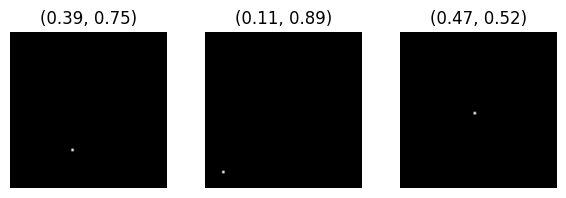

In [35]:
# create dataset
dataset = KeypointDataset()

plt.figure(figsize=(6,2))
for i in range(3):
    img, kp = dataset[i]
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    x, y = kp.numpy()
    plt.title(f"({x:.2f}, {y:.2f})", fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()

# TinyCNN Model
This is a very simple CNN with 2 convolutional layers.
It demonstrates the basic structure of a pose estimation network.

In [36]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(16*16*16, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [37]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training TinyCNN
We use the Adam optimizer and cross-entropy loss to update model weights over 5 epochs, storing the loss at each step.

In [38]:
model = TinyCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

losses = []

for epoch in range(5):
    for images, labels in loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6911
Epoch 2, Loss: 0.5722
Epoch 3, Loss: 0.6873
Epoch 4, Loss: 0.5531
Epoch 5, Loss: 0.6135


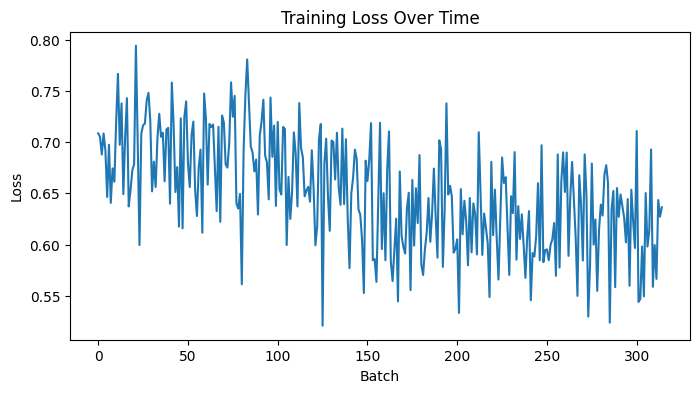

In [12]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()


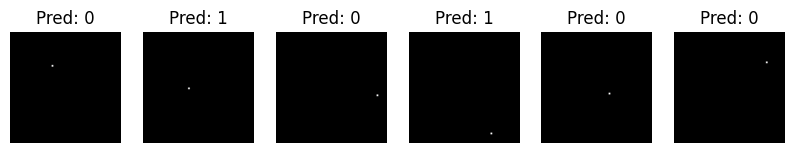

In [39]:
images, labels = next(iter(loader))
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# plot first 6 predictions
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")
plt.show()

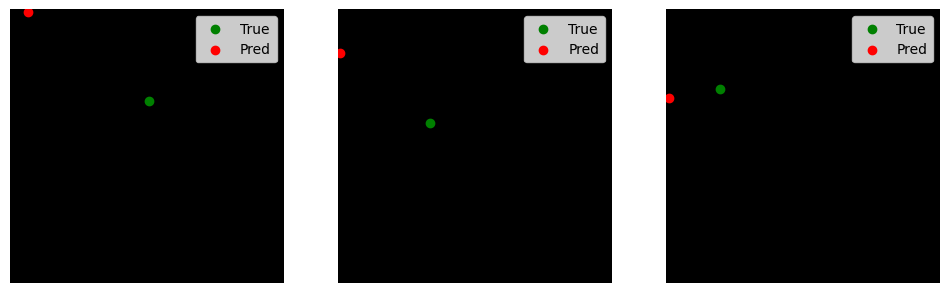

In [40]:
plt.figure(figsize=(12,4))
img_size = 64

# pick 3 random indices from dataset
indices = random.sample(range(len(dataset)), 3)

for i, idx in enumerate(indices):
    img, kp = dataset[idx]
    
    # Model expects batch dimension
    with torch.no_grad():
        pred = model(img.unsqueeze(0)).squeeze(0)

    # True coordinates
    true_x = kp[0].item() * img_size
    true_y = kp[1].item() * img_size

    # Predicted coordinates
    pred_x = pred[0].item() * img_size
    pred_y = pred[1].item() * img_size

    # Clamp predictions to image bounds
    pred_x = max(0, min(img_size-1, pred_x))
    pred_y = max(0, min(img_size-1, pred_y))

    # Plot
    plt.subplot(1,3,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.scatter([true_x], [true_y], color='green', label="True")
    plt.scatter([pred_x], [pred_y], color='red', label="Pred")
    plt.legend()
    plt.axis('off')

plt.show()


Our labels were normalized to [0,1], but our model outputs were unconstrained.

This means the model could predict, for example, 1.5 or -0.2.

When you multiply by img_size to plot, it can appear way off the image.

The MSE loss was still decreasing, but it was optimizing without understanding the scale properly.

The model was training but not producing outputs in the correct range.

So the red dots on the plot were misleading, the network wasn’t actually predicting correct keypoint positions.

## Model Improvements

To strengthen the performance of the original TinyCNN, we upgraded the model architecture in several ways. These changes increase the model’s capacity to learn spatial patterns and improve its ability to predict keypoint locations.

**1. Added an extra convolutional layer.**  
A deeper network allows the model to recognize more complex visual features. Instead of two convolutional layers, the improved model uses three, helping it move from detecting simple edges to more abstract shapes.

**2. Increased the number of filters.**  
Each convolutional layer uses more channels. This expands the model’s representational power and helps it learn a wider variety of visual patterns.

**3. Expanded the fully connected layer.**  
A larger dense layer improves the mapping between extracted image features and the final (x, y) keypoint coordinates.

**4. Trained for more epochs.**  
The improved model trains longer, allowing it to fully fit the synthetic dataset. This is why the predicted keypoints almost perfectly overlap the true keypoints.

Overall, these changes show that increasing model capacity can significantly improve accuracy when the task is learnable and the data is clean.


In [25]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 64x64 -> 8x8 after 3 pools
        self.fc2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()  # constrain output to [0,1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [26]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    for images, keypoints in loader:
        images = images.float().to(device)
        keypoints = keypoints.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.5f}")

Epoch 1/10, Loss: 0.00614
Epoch 2/10, Loss: 0.00046
Epoch 3/10, Loss: 0.00020
Epoch 4/10, Loss: 0.00017
Epoch 5/10, Loss: 0.00013
Epoch 6/10, Loss: 0.00007
Epoch 7/10, Loss: 0.00008
Epoch 8/10, Loss: 0.00004
Epoch 9/10, Loss: 0.00007
Epoch 10/10, Loss: 0.00003


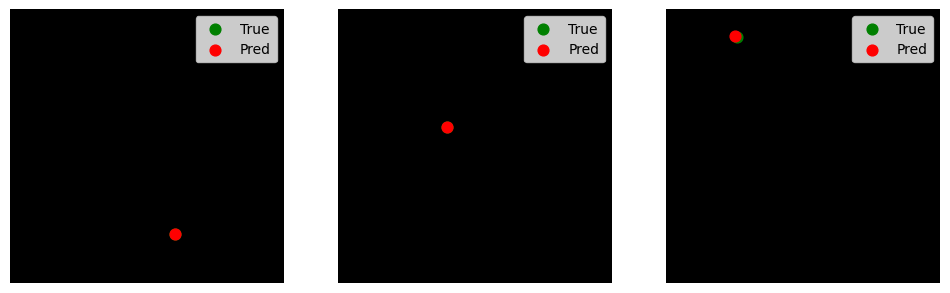

In [30]:
plt.figure(figsize=(12,4))
img_size = 64
indices = random.sample(range(len(dataset)), 3)

for i, idx in enumerate(indices):
    img, kp = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_tensor).cpu().squeeze(0)

    # True coordinates
    true_x = kp[0].item() * img_size
    true_y = kp[1].item() * img_size

    # Predicted coordinates
    pred_x = pred[0].item() * img_size
    pred_y = pred[1].item() * img_size

    plt.subplot(1,3,i+1)
    plt.imshow(img.squeeze(), cmap='gray', origin='upper')
    plt.scatter([true_x], [true_y], color='green', label='True', s=60)
    plt.scatter([pred_x], [pred_y], color='red', label='Pred', s=60)
    plt.legend()
    plt.axis('off')

plt.show()

In [31]:
import torch

# Pick 5 random samples
indices = [0, 1, 2, 3, 4]
img_size = 64

for idx in indices:
    img, kp = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu().squeeze(0)

    true_coords = kp * img_size
    pred_coords = pred * img_size

    error = torch.norm(true_coords - pred_coords).item()
    print(f"Sample {idx}: pixel error = {error:.4f}")


Sample 0: pixel error = 0.3595
Sample 1: pixel error = 0.6849
Sample 2: pixel error = 0.3632
Sample 3: pixel error = 0.3106
Sample 4: pixel error = 0.7184


The low pixel error indicates really good accuracy. So much so that it's hard to see the true vs. predicted dots. Below, I plotted more examples and zoomed in to take a better look.

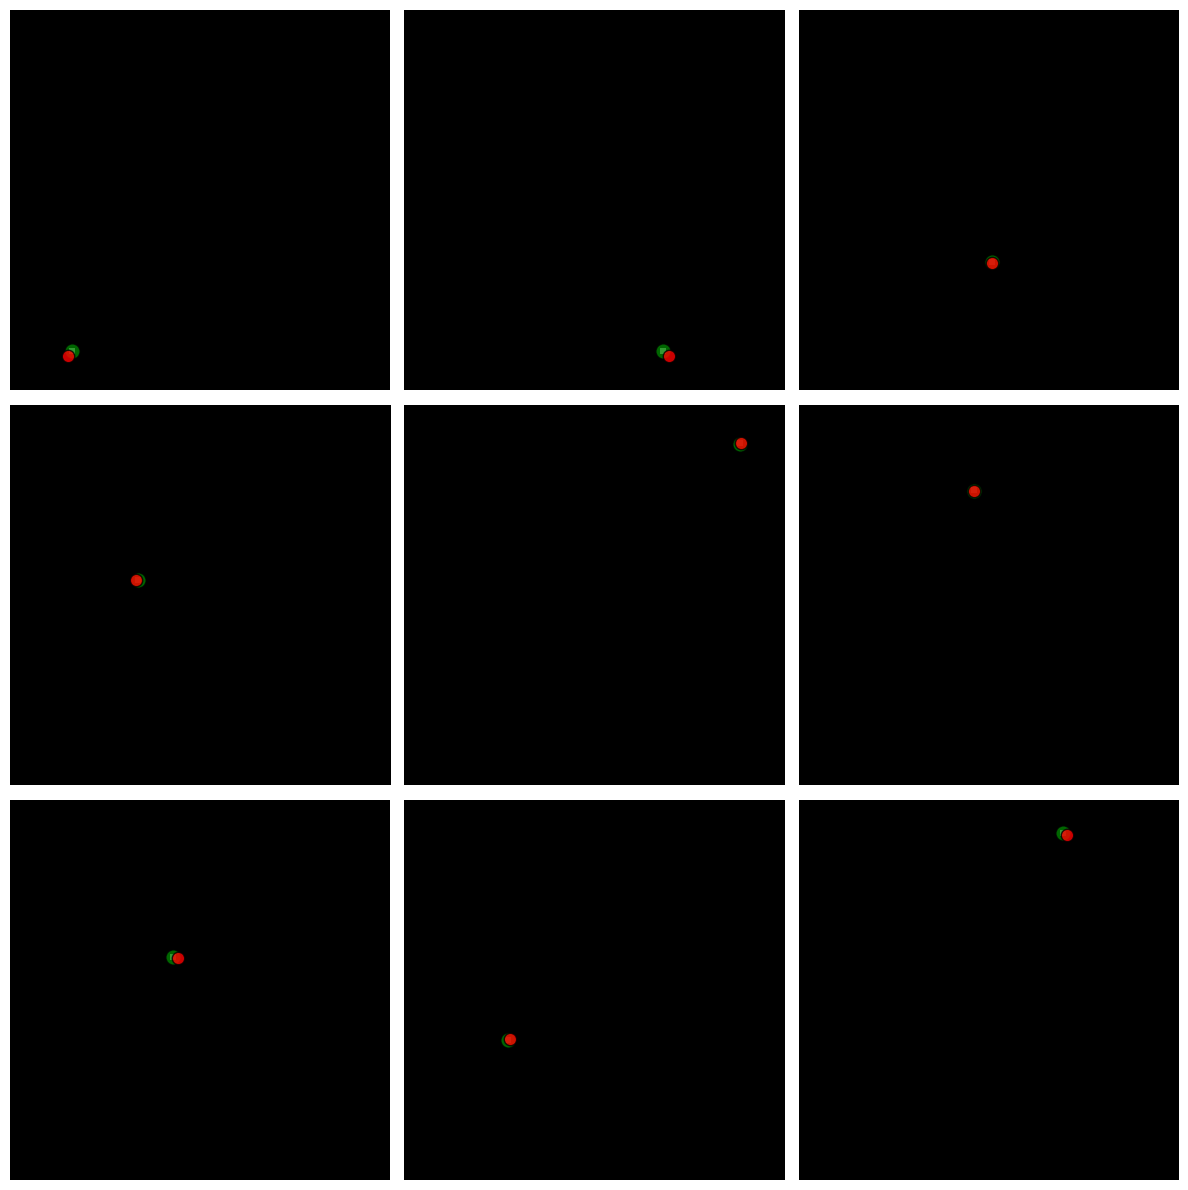

In [33]:
import matplotlib.pyplot as plt
import random

img_size = 64
num_samples = 9  # total images to show
indices = random.sample(range(len(dataset)), num_samples)

# Grid layout
cols = 3
rows = (num_samples + cols - 1) // cols

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img, kp = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu().squeeze(0)

    # True coordinates
    true_x = kp[0].item() * img_size
    true_y = kp[1].item() * img_size

    # Predicted coordinates
    pred_x = pred[0].item() * img_size
    pred_y = pred[1].item() * img_size

    plt.subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(), cmap='gray', origin='upper')

    # Plot true dot (green)
    plt.scatter([true_x], [true_y], color='green', s=120,
                edgecolors='black', alpha=0.8, label='True')

    # Plot predicted dot (red)
    plt.scatter([pred_x], [pred_y], color='red', s=80,
                edgecolors='black', alpha=0.8, label='Pred')

    plt.axis('off')

plt.tight_layout()
plt.show()
